In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as k
import os
from tensorflow.keras.layers import Input, Lambda, Conv2D, Concatenate, Conv2DTranspose, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.utils import load_img as im_read
from tensorflow.keras.utils import img_to_array

**Load preprocess and clean image dataset**

In [51]:
path = r"/kaggle/input/breast-ultrasound/Dataset_BUSI_with_GT/benign"
ls = os.listdir(path)
IMG_SIZE = 64
# function to load mask files from drive
def load_mask():
    for i in ls:
        if 'mask' in i:
            yield i
            
# function to load image files from drive
def load_image():
    for j in ls:
        if not 'mask' in j:
            yield j
            
mask_files = list(load_mask())
image_files = list(load_image())
mask_files = sorted(mask_files)
image_files = sorted(image_files)

#open mask files and convert to matrxies/arrays
mask_list = []
for idx, file in enumerate(mask_files):
    url = os.path.join(path, file)
    mask_img = img_to_array(im_read(url, target_size = (IMG_SIZE,IMG_SIZE)))
    if len(mask_img.shape) > 2:
        mask_img = mask_img.sum(axis = -1)/mask_img.shape[-1]
    mask_list.append(mask_img)

#open mask files and convert to matrxies/arrays    
image_list = []
for idx, file in enumerate(image_files):
    url = os.path.join(path, file)
    image_img = img_to_array(im_read(url, target_size=(IMG_SIZE,IMG_SIZE)))
    image_list.append(image_img)

#filter out seperated masks for rejoining 
multi_mask1_idx = [mask_files.index(file) for file in mask_files if file.split('.')[0][-1].isdigit()]
multi_mask1_idx.pop(5)
multi_mask2_idx = [i - 1 for i in multi_mask1_idx]
multi_mask3_idx = [112]
multi_max_idx = multi_mask1_idx + multi_mask2_idx + multi_mask3_idx
clean_mask_dict = dict()
for idx in range(len(multi_mask1_idx)):
    multi_mask1 = img_to_array(im_read(os.path.join(path, mask_files[multi_mask2_idx[idx]]),target_size = (IMG_SIZE,IMG_SIZE)))
    if len(multi_mask1.shape) > 2:
        multi_mask1 = multi_mask1.sum(axis = -1)/multi_mask1.shape[-1]
    multi_mask2 = img_to_array(im_read(os.path.join(path, mask_files[multi_mask1_idx[idx]]),target_size = (IMG_SIZE,IMG_SIZE)))
    if len(multi_mask2.shape) > 2:
        multi_mask2 = multi_mask2.sum(axis = -1)/multi_mask2.shape[-1]
    #fuse multiple masks
    clean_mask = np.maximum(multi_mask1, multi_mask2)
    clean_mask_dict[multi_mask2_idx[idx]] = clean_mask_dict.get(multi_mask2_idx[idx], clean_mask)
multi_mask3 = img_to_array(im_read(os.path.join(path, mask_files[multi_mask3_idx[0]]), target_size=(IMG_SIZE,IMG_SIZE)))
multi_mask3 = multi_mask3.sum(axis = -1)/multi_mask3.shape[-1]
clean_mask_dict[110] = np.maximum(clean_mask_dict.get(110), multi_mask3)

#merge all mask files to a complete dataset of labels
mask_lst = mask_list.copy()
mask_ = mask_files.copy()
cnt = 0
for idx, img in enumerate(mask_lst):
    if idx in multi_max_idx:
        mask_lst[idx] = None
        mask_[idx] = None
        cnt += 1
for idx2, img2 in clean_mask_dict.items():
    mask_lst[idx2] = img2
    mask_[idx2] = mask_files[idx2]

mask_img = [mask for mask in mask_lst if not mask is None]
mask_id = [m for m in mask_ if not m is None]

#convert images and masks into tf.data objects for easier model training
X = tf.data.Dataset.from_tensor_slices(np.array(image_list)/255.0)
y = tf.data.Dataset.from_tensor_slices(np.expand_dims(np.array(mask_img)/255, axis = -1))
data = tf.data.Dataset.zip((X,y))

#cache and prefetch to treat IO botlenecks and shuffle and batch the dataset
data = data.cache().prefetch(buffer_size = tf.data.AUTOTUNE).shuffle(buffer_size = 200).batch(32)

**Display image and mask samples**

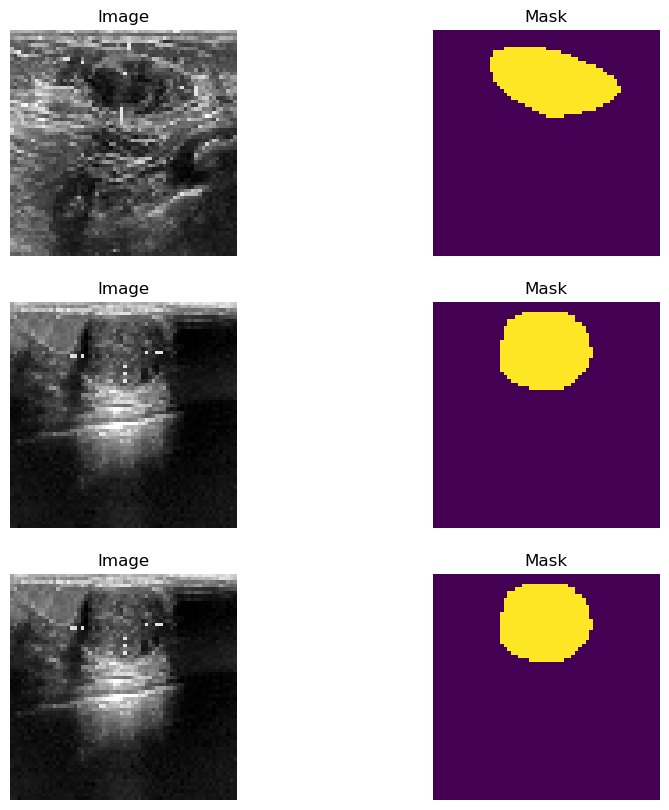

In [52]:
def display_data(data, num_img = 2):
    data_ = data.unbatch()
    fig, ax = plt.subplots(num_img, 2, figsize = (10,10))
    if num_img > 1:
        for idx in range(num_img):
            for img,mask in data_.take(1):
                ax[idx, 0].imshow(img)
                ax[idx, 0].set_axis_off()
                ax[idx, 0].set_title('Image')
                ax[idx, 1].imshow(mask)
                ax[idx, 1].set_axis_off()
                ax[idx, 1].set_title('Mask')
    else:
        for img,mask in data_.take(1):
                ax[0].imshow(img)
                ax[0].set_axis_off()
                ax[0].set_title('Image')
                ax[1].imshow(mask)
                ax[1].set_axis_off()
                ax[1].set_title('Mask')
display_data(data, 3)

**Split dataset into training, validation and test splits**

In [53]:
num_batches = data.cardinality()
val_data = data.take(num_batches//4)
train_data = data.skip(num_batches//4)
test_data = train_data.take(1)
train_data = train_data.skip(1)

# sanity check
print(f'Training set has {train_data.cardinality()} batches')
print(f'Validation set has {val_data.cardinality()} batches')
print(f'Test set has {test_data.cardinality()} batch')

Training set has 10 batches
Validation set has 3 batches
Test set has 1 batch


**Perform data augmentation by randomly tranform the training data**

**This would improve model robustness and reduce overfitting**

In [54]:
#@keras.saving.register_keras_serializable(name="Augment")
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=12):
        super().__init__()
    # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_input2 = tf.keras.layers.RandomBrightness(factor = 0.2, value_range = (0,1))

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        inputs = self.augment_input2(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels
                                          
    #def get_config(self):
        #return {"seed": seed,'augment_inputs':self.augment_inputs,'augment_labels': self.augment_labels}


train_data = train_data.map(Augment())

**View augmentated(randomly transformed) data**

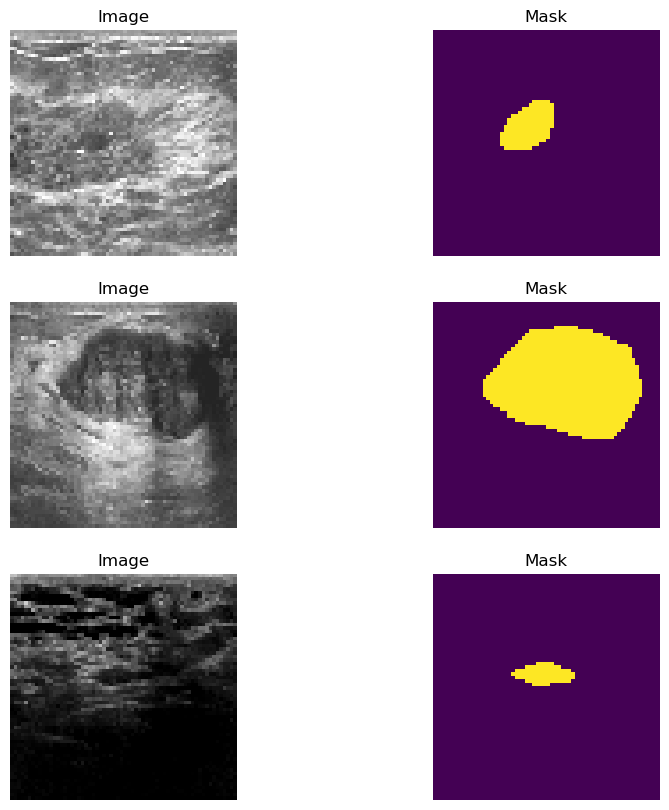

In [55]:
display_data(train_data, 3)

**Create a custom loss function (Jaccard loss)**

**Simply the additive inverse of Jaccard coefficient**

In [56]:
#@keras.saving.register_keras_serializable( name="Jac")
class Jac(tf.keras.losses.Loss):
    def __init__(self, epsilon = 0.00001):
        super().__init__()
        self.ep = epsilon
    def call(self, y_true, y_pred):
        y = k.flatten(y_true)
        p = k.flatten(y_pred)
        inter = 2 * k.sum(y * p) + self.ep
        union = k.sum(y **2) + k.sum(p ** 2) + self.ep
        return 1 - (inter / union)
    #def get_config(self):
        #return {"epsilon": self.ep}


#tf.keras.saving.get_custom_objects()['Jac'] = Jac
#sanity check
#pick two random samples from mask dataset
idx = np.random.choice(range(32))
mask1 = list(data.as_numpy_iterator())[0][1][idx]
mask2 = list(data.as_numpy_iterator())[0][1][idx]
sample_mask1 = tf.convert_to_tensor(mask1)
sample_mask2 = tf.convert_to_tensor(mask2)
#higher jaccard loss for disimilar masks
print(f'Jaccard loss for two disimilar images is {Jac()(sample_mask1, sample_mask2)}')
#lower jaccard loss for similar masks
print(f'Jaccard loss for two similar images is {Jac()(sample_mask1, sample_mask1)}')

Jaccard loss for two disimilar images is 0.7303370237350464
Jaccard loss for two similar images is 0.0


**Build U-NET model layers and apply DropOut on every layer to reduce the models complxity and enhance robustness to unseen data**

In [57]:

def U_net(input_shape = (64,64,3)):
    input = Input(shape = input_shape)
    l1 = Conv2D(16, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(input) #input shape(128x128x3)
    l2 = Conv2D(16, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l1) #input shape(128x128x16)
    l3 = MaxPooling2D((2))(l2) #input shape(128x128x16)
    
    l4 = Conv2D(32, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l3) #input shape(64x64x16)
    l4_ = Dropout(0.1)(l4) #input shape(64x64x32)
    l5 = Conv2D(32, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l4_)#input shape(64x64x32)
    l6 = MaxPooling2D((2))(l5) #input shape(64x64x32)
    
    l7 = Conv2D(64, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l6) #input shape(32x32x32)
    l7_ = Dropout(0.2)(l7) #input shape(32x32x64)
    l8 = Conv2D(64, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l7_) #input shape(32x32x64)
    l9 = MaxPooling2D((2))(l8) #input shape(32x32x64)
    
    l20 = Conv2D(128, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l9) #input shape(16x16x64)
    l20_ = Dropout(0.2)(l20) #input shape(16x16x128)
    l21 = Conv2D(128, (3,3), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l20_) #input shape(16x16x128)
    l22 = MaxPooling2D((2))(l21) #input shape(16x16x128)
    
    l23 = Conv2DTranspose(64, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same', strides = 2)(l22) #input shape(8x8x128)
    l24 = Concatenate()([l23, l9]) #input shape(16x16x64) and (16x16x64)
    l24_ = Dropout(0.2)(l24) #input shape(16x16x128)
    l25 = Conv2D(64, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l24_) #input shape(16x16x64)
    
    l26 = Conv2DTranspose(32, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same', strides = 2)(l25) #input shape(16x16x64)
    l27 = Concatenate()([l26, l6]) #input shape(32x32x32) and (32x32x32)
    l27_ = Dropout(0.5)(l27) #input shape(32x32x64)
    l28 = Conv2D(32, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l27_) #input shape(32x32x64)
    
    l29 = Conv2DTranspose(16, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same', strides = 2)(l28) #input shape(32x32x32)
    l30 = Concatenate()([l29, l3]) #input shape(64x64x16) and #input shape(64x64x16)
    l30_ = Dropout(0.5)(l30) #input shape(64x64x32)
    l31 = Conv2D(16, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l30_) #input shape(64x64x32)
    
    l32 = Conv2DTranspose(8, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same', strides = 2)(l31) #input shape(64x64x16)
    l33 = Conv2D(8, (2,2), kernel_initializer = 'he_normal', activation = 'relu', padding = 'same')(l32) #input shape(128x128x8)
    output = Conv2D(1, (1,1), kernel_initializer = 'he_normal', activation = 'sigmoid', padding = 'same')(l33) #input shape(128x128x8)
    # output shape = 128,128,1

    model = tf.keras.Model(input, output)
    return model

# View model layers and input shapes
U_net().summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 64, 64, 16)   448         ['input_7[0][0]']                
                                                                                                  
 conv2d_79 (Conv2D)             (None, 64, 64, 16)   2320        ['conv2d_78[0][0]']              
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 32, 32, 16)  0           ['conv2d_79[0][0]']              
 )                                                                                          

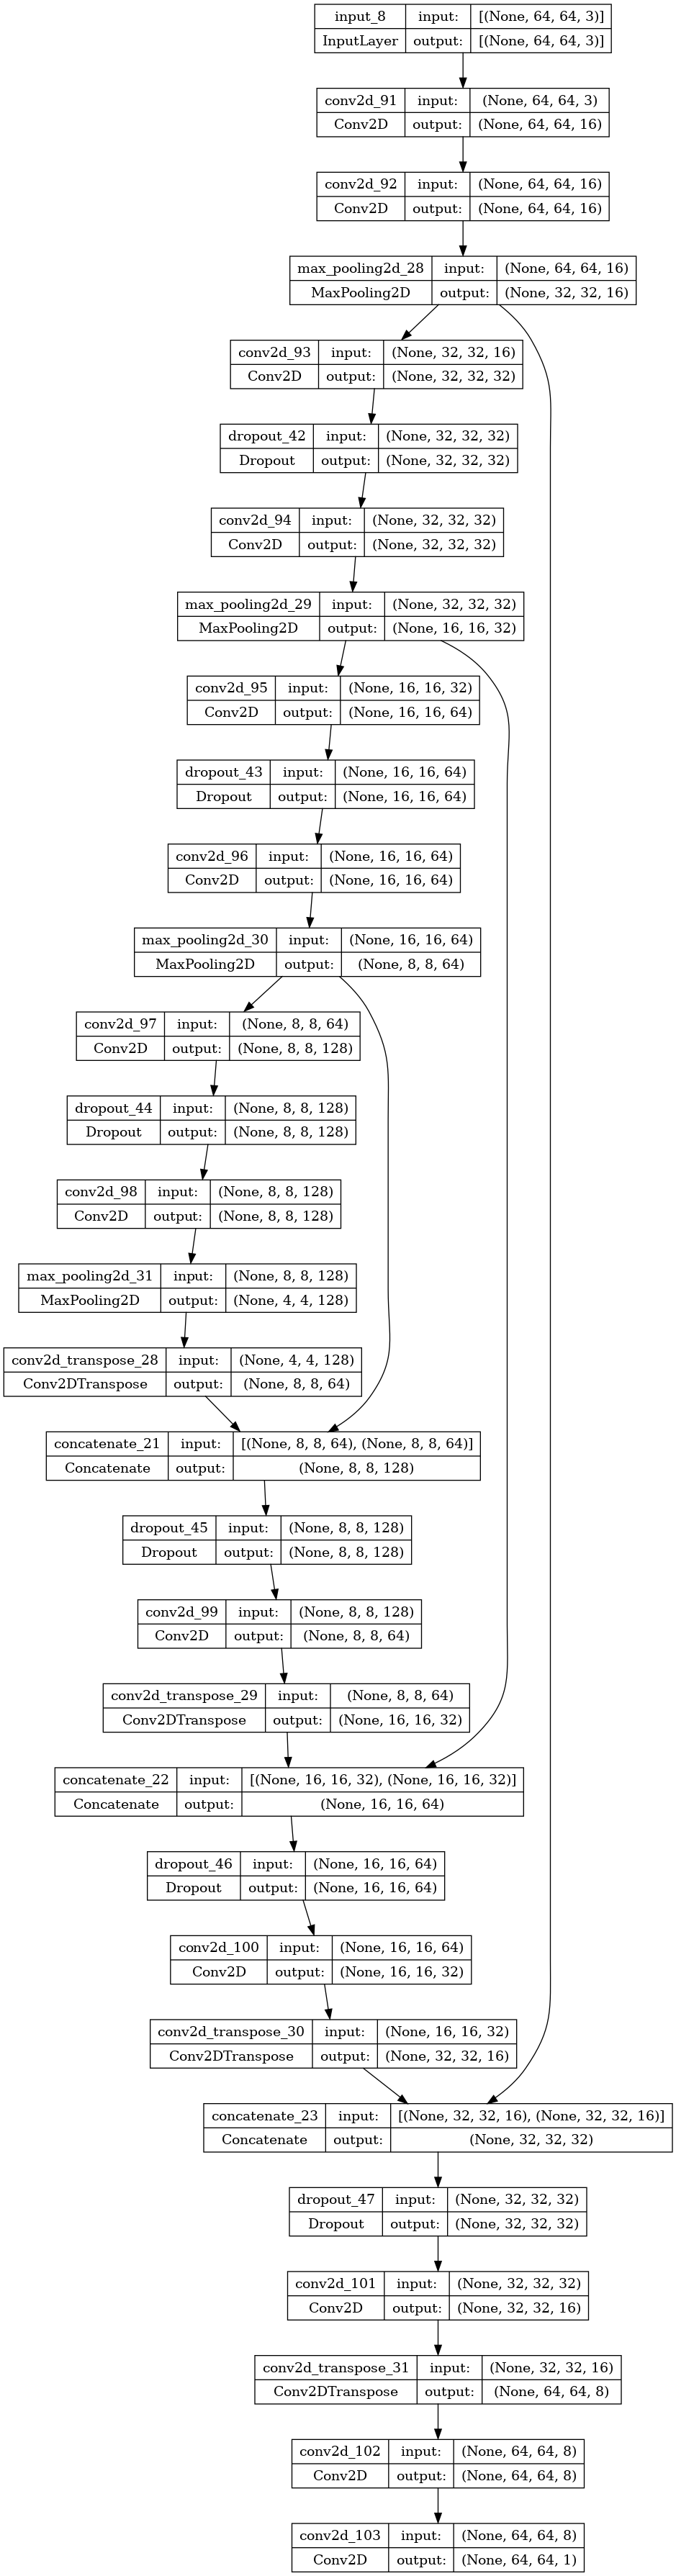

In [58]:
# Display model architecture
model = U_net()
network_graph = tf.keras.utils.plot_model(model, show_shapes = True)
network_graph

**Create a custom model evaluation metric, Jaccard Index**

In [59]:

#@keras.saving.register_keras_serializable(name = 'JAC_Metric')
class JAC_Metric(tf.keras.metrics.Metric):
    def __init__(self, name='JAC_Metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.inter = self.add_weight(name='inter', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        t = k.flatten(y_pred)
        p = k.flatten(y_true)
        self.inter.assign_add(2 * k.sum(t * p) + 0.00001)
        self.union.assign_add(k.sum(t ** 2) + k.sum(p **2) + 0.00001)

    def result(self):
        return self.inter / self.union

    def reset_state(self):
        self.inter.assign(0.0)
        self.union.assign(0.0)
    
    #def get_config(self):
        #base_config = super().get_config()
        #return base_config
    
#sanity check
#pick two random samples from mask dataset
idx = np.random.choice(range(32))
mask1 = list(data.as_numpy_iterator())[0][1][idx]
mask2 = list(data.as_numpy_iterator())[0][1][idx]
sample_mask1 = tf.convert_to_tensor(mask1)
sample_mask2 = tf.convert_to_tensor(mask2)
# lower jaccard coefficient for disimilar masks
print(f'Jaccard Coefficient for two disimilar images is {JAC_Metric()(sample_mask1, sample_mask2)}')
# higher jaccard coeffcient for two similar masks
print(f'Jaccard Coefficient for two similar images is {JAC_Metric()(sample_mask1, sample_mask1)}')


Jaccard Coefficient for two disimilar images is 0.162698432803154
Jaccard Coefficient for two similar images is 1.0


**Compile model using Adam as optimizer, jaccard loss as loss function and Jaccard index and mean intersecton over union as metrics**

**Use learning rate scheduler to gradually lower the learning rate in order to avoid saddle points**

In [60]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = Jac(), metrics = [tf.keras.metrics.MeanIoU(2), JAC_Metric()])

def scheduler(epoch, lr):
    if epoch <= 200:
        return lr
    elif epoch > 200 and epoch <= 300:
        return 0.0001
    else:
        return 0.00005

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Determine model performance before training commences**

In [61]:
Test_Jaccard_coefficient = model.evaluate(test_data)
print(f'Jaccard accuracy of test data BEFORE training is {Test_Jaccard_coefficient[2]}')

1/1 [==============================] - 1s 660ms/step - loss: 0.7953 - mean_io_u_3: 0.4675 - JAC_Metric: 0.2047
Jaccard accuracy of test data BEFORE training is 0.2046550065279007


1/1 [==============================] - 0s 205ms/step


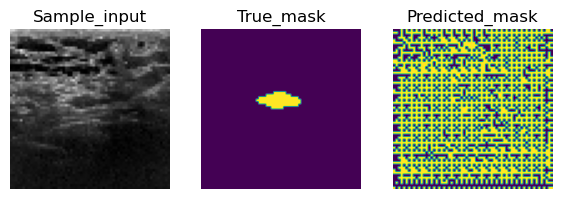

In [62]:
#create function to make and view predictions
def make_predictions(test_data):
    sample_inputs, true_masks = list(test_data.take(1))[0]
    idx = np.random.choice(32)
    sample_input = sample_inputs[idx]
    true_mask = true_masks[idx]
    sample_input_exp = tf.expand_dims(sample_input, axis = 0)
    predicted_mask = model.predict(sample_input_exp) > 0.5
    predicted_mask = predicted_mask[0]
    img_list = [sample_input, true_mask, predicted_mask]
    titles = ['Sample_input', 'True_mask', 'Predicted_mask']
    fig, ax = plt.subplots(1,3, figsize = (7,7))
    for i, img in enumerate(img_list):
        ax[i].imshow(img)
        ax[i].set_title(titles[i])
        ax[i].set_axis_off()

#call fucntion to view predictions
make_predictions(test_data)

**Train the model for 300 epochs**

In [64]:
# set a random seed for consistent results
np.random.seed(0)
history = model.fit(train_data, epochs = 300, validation_data = val_data, callbacks = [LRS])

Epoch 1/300
10/10 [==============================] - 0s 20ms/step - loss: 0.7385 - mean_io_u_3: 0.4624 - JAC_Metric: 0.2613 - val_loss: 0.7644 - val_mean_io_u_3: 0.4722 - val_JAC_Metric: 0.2360 - lr: 0.0010
Epoch 2/300
10/10 [==============================] - 0s 19ms/step - loss: 0.7325 - mean_io_u_3: 0.4642 - JAC_Metric: 0.2693 - val_loss: 0.7479 - val_mean_io_u_3: 0.4735 - val_JAC_Metric: 0.2544 - lr: 0.0010
Epoch 3/300
10/10 [==============================] - 0s 19ms/step - loss: 0.7166 - mean_io_u_3: 0.4646 - JAC_Metric: 0.2871 - val_loss: 0.7129 - val_mean_io_u_3: 0.4710 - val_JAC_Metric: 0.2877 - lr: 0.0010
Epoch 4/300
10/10 [==============================] - 0s 19ms/step - loss: 0.6454 - mean_io_u_3: 0.4637 - JAC_Metric: 0.3535 - val_loss: 0.6210 - val_mean_io_u_3: 0.4694 - val_JAC_Metric: 0.3793 - lr: 0.0010
Epoch 5/300
10/10 [==============================] - 0s 19ms/step - loss: 0.5848 - mean_io_u_3: 0.4630 - JAC_Metric: 0.4153 - val_loss: 0.5608 - val_mean_io_u_3: 0.4697 - v

**Determine model performance on test data after training**

In [65]:
Test_Jaccard_coefficient = model.evaluate(test_data)
print(f'Jaccard accuracy of test data AFTER training is {Test_Jaccard_coefficient[2]}')

1/1 [==============================] - 0s 30ms/step - loss: 0.0447 - mean_io_u_3: 0.6715 - JAC_Metric: 0.9553
Jaccard accuracy of test data AFTER training is 0.955327570438385


In [66]:
#Generate log of training data and validation losses and accuracies
df = pd.DataFrame(data = history.history)
df

,loss,mean_io_u_3,JAC_Metric,val_loss,val_mean_io_u_3,val_JAC_Metric,lr
0,0.738470,0.462363,0.261276,0.764446,0.472202,0.235970,0.0010
1,0.732484,0.464199,0.269278,0.747866,0.473474,0.254446,0.0010
2,0.716586,0.464599,0.287137,0.712877,0.470982,0.287685,0.0010
3,0.645385,0.463711,0.353459,0.621018,0.469377,0.379284,0.0010
4,0.584840,0.462981,0.415288,0.560780,0.469694,0.440704,0.0010
...,...,...,...,...,...,...,...
295,0.048238,0.675706,0.953229,0.061438,0.607893,0.937610,0.0001
296,0.051128,0.675746,0.949901,0.056469,0.645201,0.944632,0.0001
297,0.048728,0.673218,0.952395,0.063225,0.637753,0.935423,0.0001
298,0.049713,0.678857,0.951136,0.056902,0.652241,0.943243,0.0001


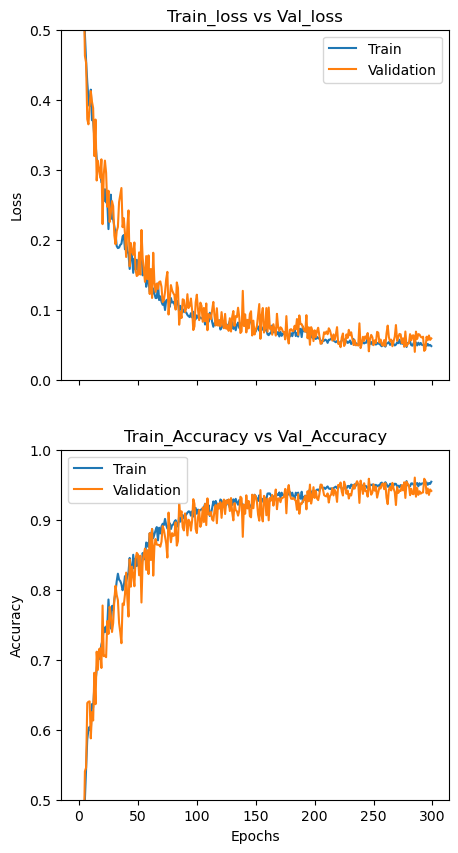

In [67]:

fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
ax[0].plot(df.index, df.loss, label = 'Train')
ax[0].plot(df.index, df.val_loss, label = 'Validation')
ax[0].set_ylim(0.0,0.5)
ax[0].set_title('Train_loss vs Val_loss')
ax[0].legend()
ax[0].set_ylabel('Loss')
ax[1].plot(df.index, df.JAC_Metric, label = 'Train')
ax[1].plot(df.index, df.val_JAC_Metric, label = 'Validation')
ax[1].set_ylim(0.5, 1.0)
ax[1].set_title('Train_Accuracy vs Val_Accuracy')
ax[1].legend()
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()

**Visualize model predicts**

1/1 [==============================] - 0s 19ms/step


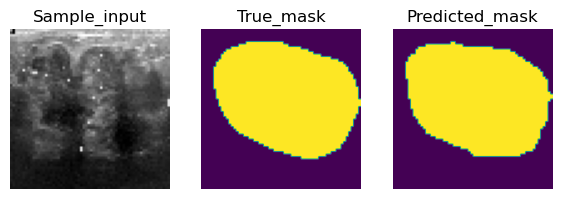

In [70]:
#create function to make and view predictions
def make_predictions(test_data):
    sample_inputs, true_masks = list(test_data.take(1))[0]
    idx = np.random.choice(32)
    sample_input = sample_inputs[idx]
    true_mask = true_masks[idx]
    sample_input_exp = tf.expand_dims(sample_input, axis = 0)
    predicted_mask = model.predict(sample_input_exp) > 0.5
    predicted_mask = predicted_mask[0]
    img_list = [sample_input, true_mask, predicted_mask]
    titles = ['Sample_input', 'True_mask', 'Predicted_mask']
    fig, ax = plt.subplots(1,3, figsize = (7,7))
    for i, img in enumerate(img_list):
        ax[i].imshow(img)
        ax[i].set_title(titles[i])
        ax[i].set_axis_off()

#call fucntion to view predictions
make_predictions(test_data)

**Save the model in .tf format**

In [71]:
!mkdir saved_seg_model
model.save('saved_seg_model/breast_lesion_detection.tf', save_format = 'tf')

In [72]:
# sanity check on saved model
loaded_model = tf.keras.models.load_model(r'/kaggle/working/saved_seg_model/breast_lesion_detection.tf', compile = False)
print(f'Loaded model has {len(loaded_model.layers)} layers')

Loaded model has 31 layers


In [73]:
#compress .tf model file into a zip folder
import shutil
shutil.make_archive('/kaggle/working/saved_seg_model/breast_lesion_detection.tf', 'zip', '/kaggle/working/saved_seg_model/breast_lesion_detection.tf')


'/kaggle/working/saved_seg_model/breast_lesion_detection.tf.zip'